In [1]:
# Import libraries
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import nibabel as nib
from sklearn.svm import SVR
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import r2_score, roc_curve, auc
import SimpleITK as sitk
import six
from radiomics import featureextractor 
import numpy as np
import os
import pickle
import pandas as pd
import logging
import scipy
from scipy.stats import linregress
from sklearn.linear_model import QuantileRegressor
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import r_regression
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import RANSACRegressor
import os
import sys
sys.path.append('../')
import matplotlib.pyplot as plt
from pylab import rcParams
import pandas as pd
import warnings
from sklearnex import patch_sklearn, config_context
from sklearn.cluster import DBSCAN
from sklearn.exceptions import ConvergenceWarning
from sklearn import preprocessing as skp
from sklearn import model_selection as sms
from sklearn import feature_selection as skf
from sklearn import linear_model as slm
import numpy as np
import scipy.stats as stats
from IPython.display import HTML
import util as util
import nibabel as nib
import os
import pickle
patch_sklearn()

Skipping torch import


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
plt.style.use('dark_background')
plt.rcParams["figure.figsize"] = (15,5)
def remove_keymap_conflicts(new_keys_set):
    for prop in plt.rcParams:
        if prop.startswith('keymap.'):
            keys = plt.rcParams[prop]
            remove_list = set(keys) & new_keys_set
            for key in remove_list:
                keys.remove(key)

def multi_slice_viewer(volume):
    remove_keymap_conflicts({'j', 'k'})
    fig, ax = plt.subplots()
    ax.volume = volume
    ax.index = volume.shape[0]//2
    ax.imshow(volume[ax.index])
    fig.canvas.mpl_connect('key_press_event', process_key)

def process_key(event):
    fig = event.canvas.figure
    ax = fig.axes[0]
    if event.key == 'j':
        previous_slice(ax)
    elif event.key == 'k':
        next_slice(ax)
    fig.canvas.draw()
    

def previous_slice(ax):
    volume = ax.volume
    ax.index = (ax.index-1) % volume.shape[0] 
    ax.images[0].set_array(volume[ax.index])

def next_slice(ax):
    volume = ax.volume
    ax.index = (ax.index+1) % volume.shape[0]
    ax.images[0].set_array(volume[ax.index])

In [3]:
# Set window level
level = 0
window = 500
m1=level-window/2
m2=level+window/2
visualize = 1
# Load data
nrows = 256
ncols = 256
nslices = 160
segs = []
qsms = []
laros = []
voxel_sizes = []
trackers = []
q_directory = '/data/Ali/RadDBS-QSM/data/nii/chh/orig/qsm/'
q_directory = os.listdir(q_directory)
q_directory = sorted(q_directory)
qu_directory = '/data/Ali/RadDBS-QSM/data/nii/chh/lr_roi_ft'
qu_directory = os.listdir(qu_directory)
qu_directory = sorted(qu_directory)
s_directory = '/data/Ali/RadDBS-QSM/data/nii/chh/orig/seg/'
s_directory = os.listdir(s_directory)
s_directory = sorted(s_directory)
m_directory = '/data/Ali/RadDBS-QSM/data/nii/chh/masks'
m_directory = os.listdir(m_directory)
m_directory = sorted(m_directory)
case_list = []
d_count = 0
if visualize == 1:
    for filename in q_directory:
    
        seg_filename = s_directory[d_count]
        laro_filename = qu_directory[d_count]
        mask_filename = m_directory[d_count]
        seg = nib.load('/data/Ali/RadDBS-QSM/data/nii/chh/orig/seg/'+seg_filename)
        mask = nib.load('/data/Ali/RadDBS-QSM/data/nii/chh/masks/'+mask_filename)
        voxel_size = seg.header['pixdim'][0:3]
        voxel_sizes.append(voxel_size)
        segs.append(seg.get_fdata()[:nrows,:ncols,:nslices])
        qsm = nib.load('/data/Ali/RadDBS-QSM/data/nii/chh/orig/qsm/'+filename)
        qsms.append(qsm.get_fdata()[:nrows,:ncols,:nslices])

        laro = nib.load('/data/Ali/RadDBS-QSM/data/nii/chh/lr_roi_ft/'+laro_filename)
        laros.append(1000*laro.get_fdata()[:nrows,:ncols,:nslices])
        print('Appending arrays with segmentation',seg_filename,'QSM,',filename,
              'LARO,',laro_filename,'and mask',mask_filename)
        case_list.append(filename)
        n_cases = len(segs)
        d_count = d_count+1




Appending arrays with segmentation 01_roi_combined.nii QSM, 00001_qsm.nii.gz LARO, QSM_lrr_01.nii and mask mask01.nii
Appending arrays with segmentation 02_roi_combined.nii QSM, 00002_qsm.nii.gz LARO, QSM_lrr_02.nii and mask mask02.nii
Appending arrays with segmentation 03_roi_combined.nii QSM, 00003_qsm.nii.gz LARO, QSM_lrr_03.nii and mask mask03.nii
Appending arrays with segmentation 04_roi_combined.nii QSM, 00004_qsm.nii.gz LARO, QSM_lrr_04.nii and mask mask04.nii
Appending arrays with segmentation 05_roi_combined.nii QSM, 00005_qsm.nii.gz LARO, QSM_lrr_05.nii and mask mask05.nii
Appending arrays with segmentation 06_roi_combined.nii QSM, 00006_qsm.nii.gz LARO, QSM_lrr_06.nii and mask mask06.nii
Appending arrays with segmentation 07_roi_combined.nii QSM, 00007_qsm.nii.gz LARO, QSM_lrr_07.nii and mask mask07.nii
Appending arrays with segmentation 08_roi_combined.nii QSM, 00008_qsm.nii.gz LARO, QSM_lrr_08.nii and mask mask08.nii
Appending arrays with segmentation 09_roi_combined.nii Q

In [4]:
df = pd.read_csv('/data/Ali/RadDBS-QSM/data/xlxs/updrs_iii_chh_cvs_nt.csv')
df

,subjects,LCT,Unnamed: 2,UPDRSⅢ,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14
0,NaN,NaN,NaN,Preoperative Off-Medicine,Preoperative On-Medicine,Postoperative Off-Medicine &Off-Stimulation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"""",Postoperative Off-Medicine &On-Stimulation,Postoperative On-Medicine &On-Stimulation,age,"Gender(male=0,female=1)",Disease duration(years),LEDD,NaN,NaN,NaN,NaN,NaN,pre_off_nt,pre_on_nt,post_on
2,1,62.26%,NaN,53,20,40,15,7.0,66.0,1.0,9.0,825.00,39,13,12
3,2,75.00%,NaN,32,8,26,17,10.0,64.0,1.0,6.0,856.25,31,8,17
4,3,51.72%,NaN,58,28,52,18,20.0,67.0,1.0,15.0,1350.00,48,26,18
5,4,22.58%,NaN,62,48,61,36,28.0,69.0,1.0,5.0,350.00,54,39,36
6,5,55.88%,NaN,34,15,44,29,22.0,63.0,1.0,10.0,751.25,34,15,29
7,6,75.44%,NaN,57,14,55,32,16.0,67.0,1.0,5.0,525.00,34,13,23
8,7,84.00%,NaN,100,16,68,12,NaN,58.0,0.0,10.0,1087.50,72,16,12
9,8,41.86%,NaN,43,25,48,26,26.0,74.0,1.0,10.0,550.00,38,25,26


In [5]:
# Patient IDs
subject_id = np.asarray(df[df.columns[0]])[2:]

# Only extract ROI if it is present in all cases
seg_labels_all = segs[0]
case_number = np.zeros_like(np.asarray(s_directory))
for i in range(n_cases):
    case_number[i] = int(s_directory[i][:2])
subject_id_corr = subject_id[np.in1d(subject_id,case_number)]
age = np.nan_to_num(np.asarray(df[df.columns[-7]])[2:][np.in1d(subject_id,case_number)].astype(float))
sex = np.nan_to_num(np.asarray(df[df.columns[-3]])[2:][np.in1d(subject_id,case_number)].astype(float))
dd = np.nan_to_num(np.asarray(df[df.columns[-5]])[2:][np.in1d(subject_id,case_number)].astype(float))
ledd = np.nan_to_num(np.asarray(df[df.columns[-4]])[2:][np.in1d(subject_id,case_number)].astype(float))

for i in np.arange(n_cases):
    try:
        print('Found ROIs',str(np.unique(segs[i])),'at segmentation directory file',s_directory[i],'for case',str(subject_id_corr[i]))
    except:
        print('Case',subject_id[i],'quarantined')


Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 01_roi_combined.nii for case 1
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 02_roi_combined.nii for case 2
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 03_roi_combined.nii for case 3
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 04_roi_combined.nii for case 4
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 05_roi_combined.nii for case 5
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 06_roi_combined.nii for case 6
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 07_roi_combined.nii for case 7
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 08_roi_combined.nii for case 8
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 09_roi_combined.nii for case 9
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at segmentation directory file 10_roi_combined.nii for case 10
Found ROIs [0. 1. 2. 3. 4. 5. 6.] at se

In [6]:
pre_updrs_iii_off = np.asarray((df[df.columns[-3]])[2:][np.hstack((np.in1d(subject_id,subject_id_corr)))])                         
pre_updrs_iii_on = np.asarray((df[df.columns[-2]])[2:][np.hstack((np.in1d(subject_id,subject_id_corr)))])   
post_updrs_iii_off = np.asarray((df[df.columns[-1]])[2:][np.hstack((np.in1d(subject_id,subject_id_corr)))])   
per_change = (np.asarray(pre_updrs_iii_off).astype(float)-np.asarray(post_updrs_iii_off).astype(float))/(np.asarray(pre_updrs_iii_off).astype(float))
lct_change = (np.asarray(pre_updrs_iii_off).astype(float)-(np.asarray(pre_updrs_iii_on)).astype(float))/(np.asarray(pre_updrs_iii_off).astype(float))

In [7]:
logger = logging.getLogger("radiomics")
logger.setLevel(logging.ERROR)

reextract = 0

# Assume all voxel sizes are identical
voxel_size = (0.9,0.9,0.9)
if reextract == 1:
    # Generate feature structure Phi from all ROIs and all cases
    extractor = featureextractor.RadiomicsFeatureExtractor()
    extractor.enableAllFeatures()
    extractor.enableAllImageTypes()
    extractor.enableFeatureClassByName('shape2D',enabled = False)

    seg_labels_all = np.unique(np.asarray(segs))
    Phi_gt = []
    Phi_vd = []
    Phi_lr = []
    seg_labels = []
    reextract = 0
    x_row_gt = []
    x_row_lr = []

    keylib = []
    roilib = []
    loop_count = 1
    n_rois = seg_labels_all[seg_labels_all>0].__len__()
    roi_names = np.asarray(['Background','Right substantia nigra','Right subthalamic nucleus',
                            'Left subthalamic nucleus', 'Left substantia nigra', 'Right dentate nucleus', 'Left dentate nucleus'])
    for i in np.arange(subject_id_corr.__len__()):
        seg_sitk = sitk.GetImageFromArray(segs[i])
        seg_sitk.SetSpacing(voxel_size)
        qsm_sitk_gt = sitk.GetImageFromArray(qsms[i])
        qsm_sitk_gt.SetSpacing(voxel_size)
        qsm_sitk_lr = sitk.GetImageFromArray(laros[i])
        qsm_sitk_lr.SetSpacing(voxel_size)
        # Index back since subject 12 is missing ROIs
        for j in seg_labels_all:
            if j>0:
                fv_count = 0
                featureVector_gt = extractor.execute(qsm_sitk_gt,seg_sitk,label=int(j));
                featureVector_lr = extractor.execute(qsm_sitk_lr,seg_sitk,label=int(j));
                Phi_gt.append(featureVector_gt)
                Phi_lr.append(featureVector_lr)
                for key, value in six.iteritems(featureVector_gt):
                    if 'diagnostic' in key:
                        next
                    else:
                        x_row_gt.append(featureVector_gt[key])
                        x_row_lr.append(featureVector_lr[key])
                        fv_count = fv_count+1
                        keylib.append(key)
                        roilib.append(roi_names[int(j)])
                x_row_gt.append(pre_updrs_iii_off[i])
                x_row_lr.append(pre_updrs_iii_off[i])
                fv_count = fv_count+1
        print('Extracting features for subject',subject_id_corr[i],'and appending feature matrix with vector of length',fv_count,'with UPDRS score',pre_updrs_iii_off[i])
                
    X0_gt = np.array(x_row_gt)
    X0_lr = np.array(x_row_lr)
    np.save('/home/ali/RadDBS-QSM/data/npy/rp/X0_gt_chh_rois_rp.npy',X0_gt)
    np.save('/home/ali/RadDBS-QSM/data/npy/rp/X0_lr_chh_rois_rp.npy',X0_lr)

    K = np.asarray(keylib)
    R = np.asarray(roi_names)
    np.save('/home/ali/RadDBS-QSM/data/npy/rp/K_chh_rp.npy',K)
    np.save('/home/ali/RadDBS-QSM/data/npy/rp/R_chh_rp.npy',R)

    print('Saving ground truth feature vector')
    with open('/home/ali/RadDBS-QSM/data/npy/rp/Phi_mcl_gt_roi_chh_rp', 'wb') as fp:  
        pickle.dump(Phi_gt, fp)
    
    print('Saving undersampled feature vector')
    with open('/home/ali/RadDBS-QSM/data/npy/rp/Phi_mcl_lr_roi_chh_rp', 'wb') as fp:  
        pickle.dump(Phi_lr, fp)

else:
    X0_gt = np.load('/data/Ali/RadDBS-QSM/data/npy/rp/X0_gt_chh_rois_rp.npy')
    K = np.load('/data/Ali/RadDBS-QSM/data/npy/rp/K_chh_rp.npy')
    R = np.load('/data/Ali/RadDBS-QSM/data/npy/rp/R_chh_rp.npy')
    n_rois = R.shape[0]-1
    with open('/data/Ali/RadDBS-QSM/data/npy/rp/Phi_mcl_gt_roi_chh_rp', "rb") as fp:  
        Phi_gt = pickle.load(fp)
    
    

In [8]:
n_features = 1596
n_rois = 6
X_all_c = X0_gt.reshape(n_cases,n_rois,n_features)[:,0:4,:]
K_all_c = K.reshape(n_cases,n_rois,n_features-1)[:,0:4,:]
K_all_c = np.char.add(K_all_c[0,:,:].reshape(-1,1),' ')
R_all_c = np.repeat(R[1:5],n_features-1)
K_all_c = np.char.add(np.squeeze(K_all_c),np.squeeze(R_all_c))
K_all_c = np.append(K_all_c,['pre updrs']*5)
R_all_c = np.append(R_all_c,['pre updrs']*5)
K_all_c = np.append(K_all_c,['age'])
R_all_c = np.append(R_all_c,['age'])
K_all_c = np.append(K_all_c,['disease duration'])
R_all_c = np.append(R_all_c,['disease duration'])
K_all_c = np.append(K_all_c,['sex'])
R_all_c = np.append(R_all_c,['sex'])
# K_all_c = np.append(K_all_c,['ledd'])
# R_all_c = np.append(R_all_c,['ledd'])

In [9]:
n_cases = len(per_change)
n_roisc = Phi_gt.__len__()/n_cases
L = int(len(X0_gt)/n_cases)
n_features = int(L/n_rois)
subsc = subject_id_corr
pre_updrs_off = pre_updrs_iii_off
results_ls_aug = np.zeros_like(per_change)

results_lgr_aug = np.zeros_like(per_change)
results_lgrp_aug = np.zeros_like(per_change)
results_ls = np.zeros_like(per_change)
results_lgr = np.zeros_like(per_change)
results_lgrp = np.zeros_like(per_change)
r = 1

In [10]:
retrain = 1

In [11]:
if not sys.warnoptions:
    warnings.simplefilter("ignore",category=ConvergenceWarning)
    os.environ["PYTHONWARNINGS"] = "ignore::UserWarning"


In [12]:
Js = []
aug = True
err_var = np.zeros_like(per_change)
rerror = np.zeros_like(per_change)
kappa = []
c = 0
cvn = 5
X_in = X_all_c


retrain = 1
if retrain == 1:
  for j in np.arange(c,len(subsc)):
      test_id = subsc[j]
      test_index = subsc == test_id
      train_index = subsc != test_id
      X_train = X_in[train_index,:,:]
      X_test = X_in[test_index,:,:]
      y_train0 = per_change[train_index]
      y_test = per_change[test_index]
      yt = np.mean(y_train0)
      y_cat = y_train0 <= yt

                                              
      X0_ss00,scaler_ss,X_test_ss0 = util.model_scale(skp.StandardScaler(),
                                                    X_train,train_index,X_test,
                                                    test_index,pre_updrs_iii_off,None,None,None,None,
                                                    None,None,None,None,None,False,False,False)
      # Cross validation
      cv_scores = np.zeros((cvn+1,1))
      rs = 1
      np.random.seed(rs)
      idy = np.where(np.logical_or((np.logical_or(y_train0==np.min(y_train0),
                                                  y_train0==np.min(y_train0))),
                                                  np.in1d(subsc[train_index],
                                                          np.random.choice(subsc[train_index],
                                                                           cvn-3))))

      #print(idy)
      rcfs = 1000 
      (mu, sigma) = stats.norm.fit(y_train0)
      kappa = stats.skew(y_train0)
      #print('Label distribution of:',mu,sigma,kappa)
      Q = 10
      y_train_n = y_train0
      X0_ss0_n = X0_ss00
      for jj in np.arange(Q):
       # Resample to avoid stratification errors
          np.random.seed(rs)
          idyr = np.random.choice(np.asarray(idy).ravel())
          X0_ss00 = np.append(X0_ss00,X0_ss00[idyr,:].reshape(1,-1),axis=0)
          y_train0 = np.append(y_train0,y_train0[idyr])
          rs = rs+1
          if aug == True:
            y_train_n = np.append(y_train_n,y_train0+(1.96*sigma)*np.random.normal(0,1,1))
            X0_ss0_n = np.append(X0_ss0_n,X0_ss00,axis=0)

      y_train = y_train_n
      X0_ss0 = X0_ss0_n
      for jj in np.arange(2,cvn+1): #cvn best
        skf_g = sms.StratifiedKFold(n_splits=jj,shuffle=True,random_state=0)
        y_cat = np.in1d(subsc[train_index],idy)
        skf_gen = skf_g.split(X0_ss0,y_cat)
        lasso = slm.LassoLarsCV(max_iter=1000,cv=jj,n_jobs=-1,normalize=False,eps=0.1)
        with warnings.catch_warnings() and np.errstate(divide='ignore', invalid='ignore'):
          # Feature selection
          warnings.filterwarnings("ignore", category=ConvergenceWarning)
          sel = skf.RFECV(lasso,step=rcfs,cv=jj)
          X0_ss = sel.fit_transform(X0_ss0,y_train)
          est_ls = lasso.fit(X0_ss,y_train)
          cv_scores[jj] = est_ls.score(X0_ss,y_train)
          # print('LassoCV score for',jj,'is',cv_scores[jj],'from dataset of size',X0_ss.shape)
          
      with warnings.catch_warnings() and np.errstate(divide='ignore', invalid='ignore'):        
        best_cv = np.argmax(cv_scores)

        # Fit whole dataset with optimal cv
        lasso = slm.LassoLarsCV(max_iter=1000,cv=best_cv,n_jobs=-1,normalize=False,eps=0.1)
        warnings.filterwarnings("ignore", category=ConvergenceWarning)
        sel = skf.RFECV(lasso,step=rcfs,cv=best_cv)
        X0_sst = sel.fit_transform(X0_ss0,y_train)
        X_test_sst = sel.transform(X_test_ss0)
        X0_ss = X0_sst
        X_test_ss = X_test_sst

      # LASSO
      with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning)
        lasso = slm.LassoLarsCV(max_iter=1000,cv=best_cv,n_jobs=-1,normalize=False,eps=0.1)
        est_ls = lasso.fit(X0_sst,y_train)
        results_ls_aug[c] = est_ls.predict(X_test_sst)
        if results_ls_aug[c] < np.min(y_train0):
            dx, y_n = cKDTree(X0_ss00).query(X_test_ss0, k=1)
            results_ls_aug[c] = y_train0[y_n]
            print('Using nearest neighbor')
        print('Lasso predicts',str(np.round(results_ls_aug[c],4)),
              'for',subsc[c], 'case with',str(np.round(np.repeat(per_change,r)[c],2)),'using',X0_sst.shape[1],'features and selected CV',best_cv)
        # try:
        #   K_nz.append(np.squeeze(K_ss)[est_ls.coef_>0])
        # except:
        #   print('No features appended')
        c=c+1

  # np.save('msw_results_ls_aug_ol.npy',results_ls_aug)
else:
  results_ls_aug = np.load('msw_results_ls_aug_ol.npy')

  


Lasso predicts 0.6757 for 1 case with 0.69 using 6385 features and selected CV 3
Lasso predicts 0.3327 for 2 case with 0.45 using 5385 features and selected CV 5
Lasso predicts 0.4633 for 3 case with 0.62 using 6385 features and selected CV 5
Lasso predicts 0.4967 for 4 case with 0.33 using 6385 features and selected CV 2
Lasso predicts 0.283 for 5 case with 0.15 using 5385 features and selected CV 3
Lasso predicts 0.3524 for 6 case with 0.32 using 5385 features and selected CV 3
Lasso predicts 0.4505 for 7 case with 0.83 using 3385 features and selected CV 5
Lasso predicts 0.1502 for 8 case with 0.32 using 3385 features and selected CV 5
Lasso predicts 0.5246 for 9 case with 0.49 using 6385 features and selected CV 5
Lasso predicts 0.3806 for 10 case with 0.81 using 4385 features and selected CV 2
Lasso predicts 0.6085 for 11 case with 0.57 using 6385 features and selected CV 2
Lasso predicts 0.4609 for 13 case with 0.67 using 6385 features and selected CV 2
Lasso predicts 0.3556 for 

In [13]:
lr = stats.linregress(results_ls_aug,per_change)
lr.rvalue, lr.pvalue

(0.5338633408657155, 0.0006665809483247919)

../util.py:1202: RuntimeWarning: invalid value encountered in sqrt
  tr = r*np.sqrt(n-2)/(np.sqrt(1-r**2))
../util.py:1202: RuntimeWarning: invalid value encountered in sqrt
  tr = r*np.sqrt(n-2)/(np.sqrt(1-r**2))


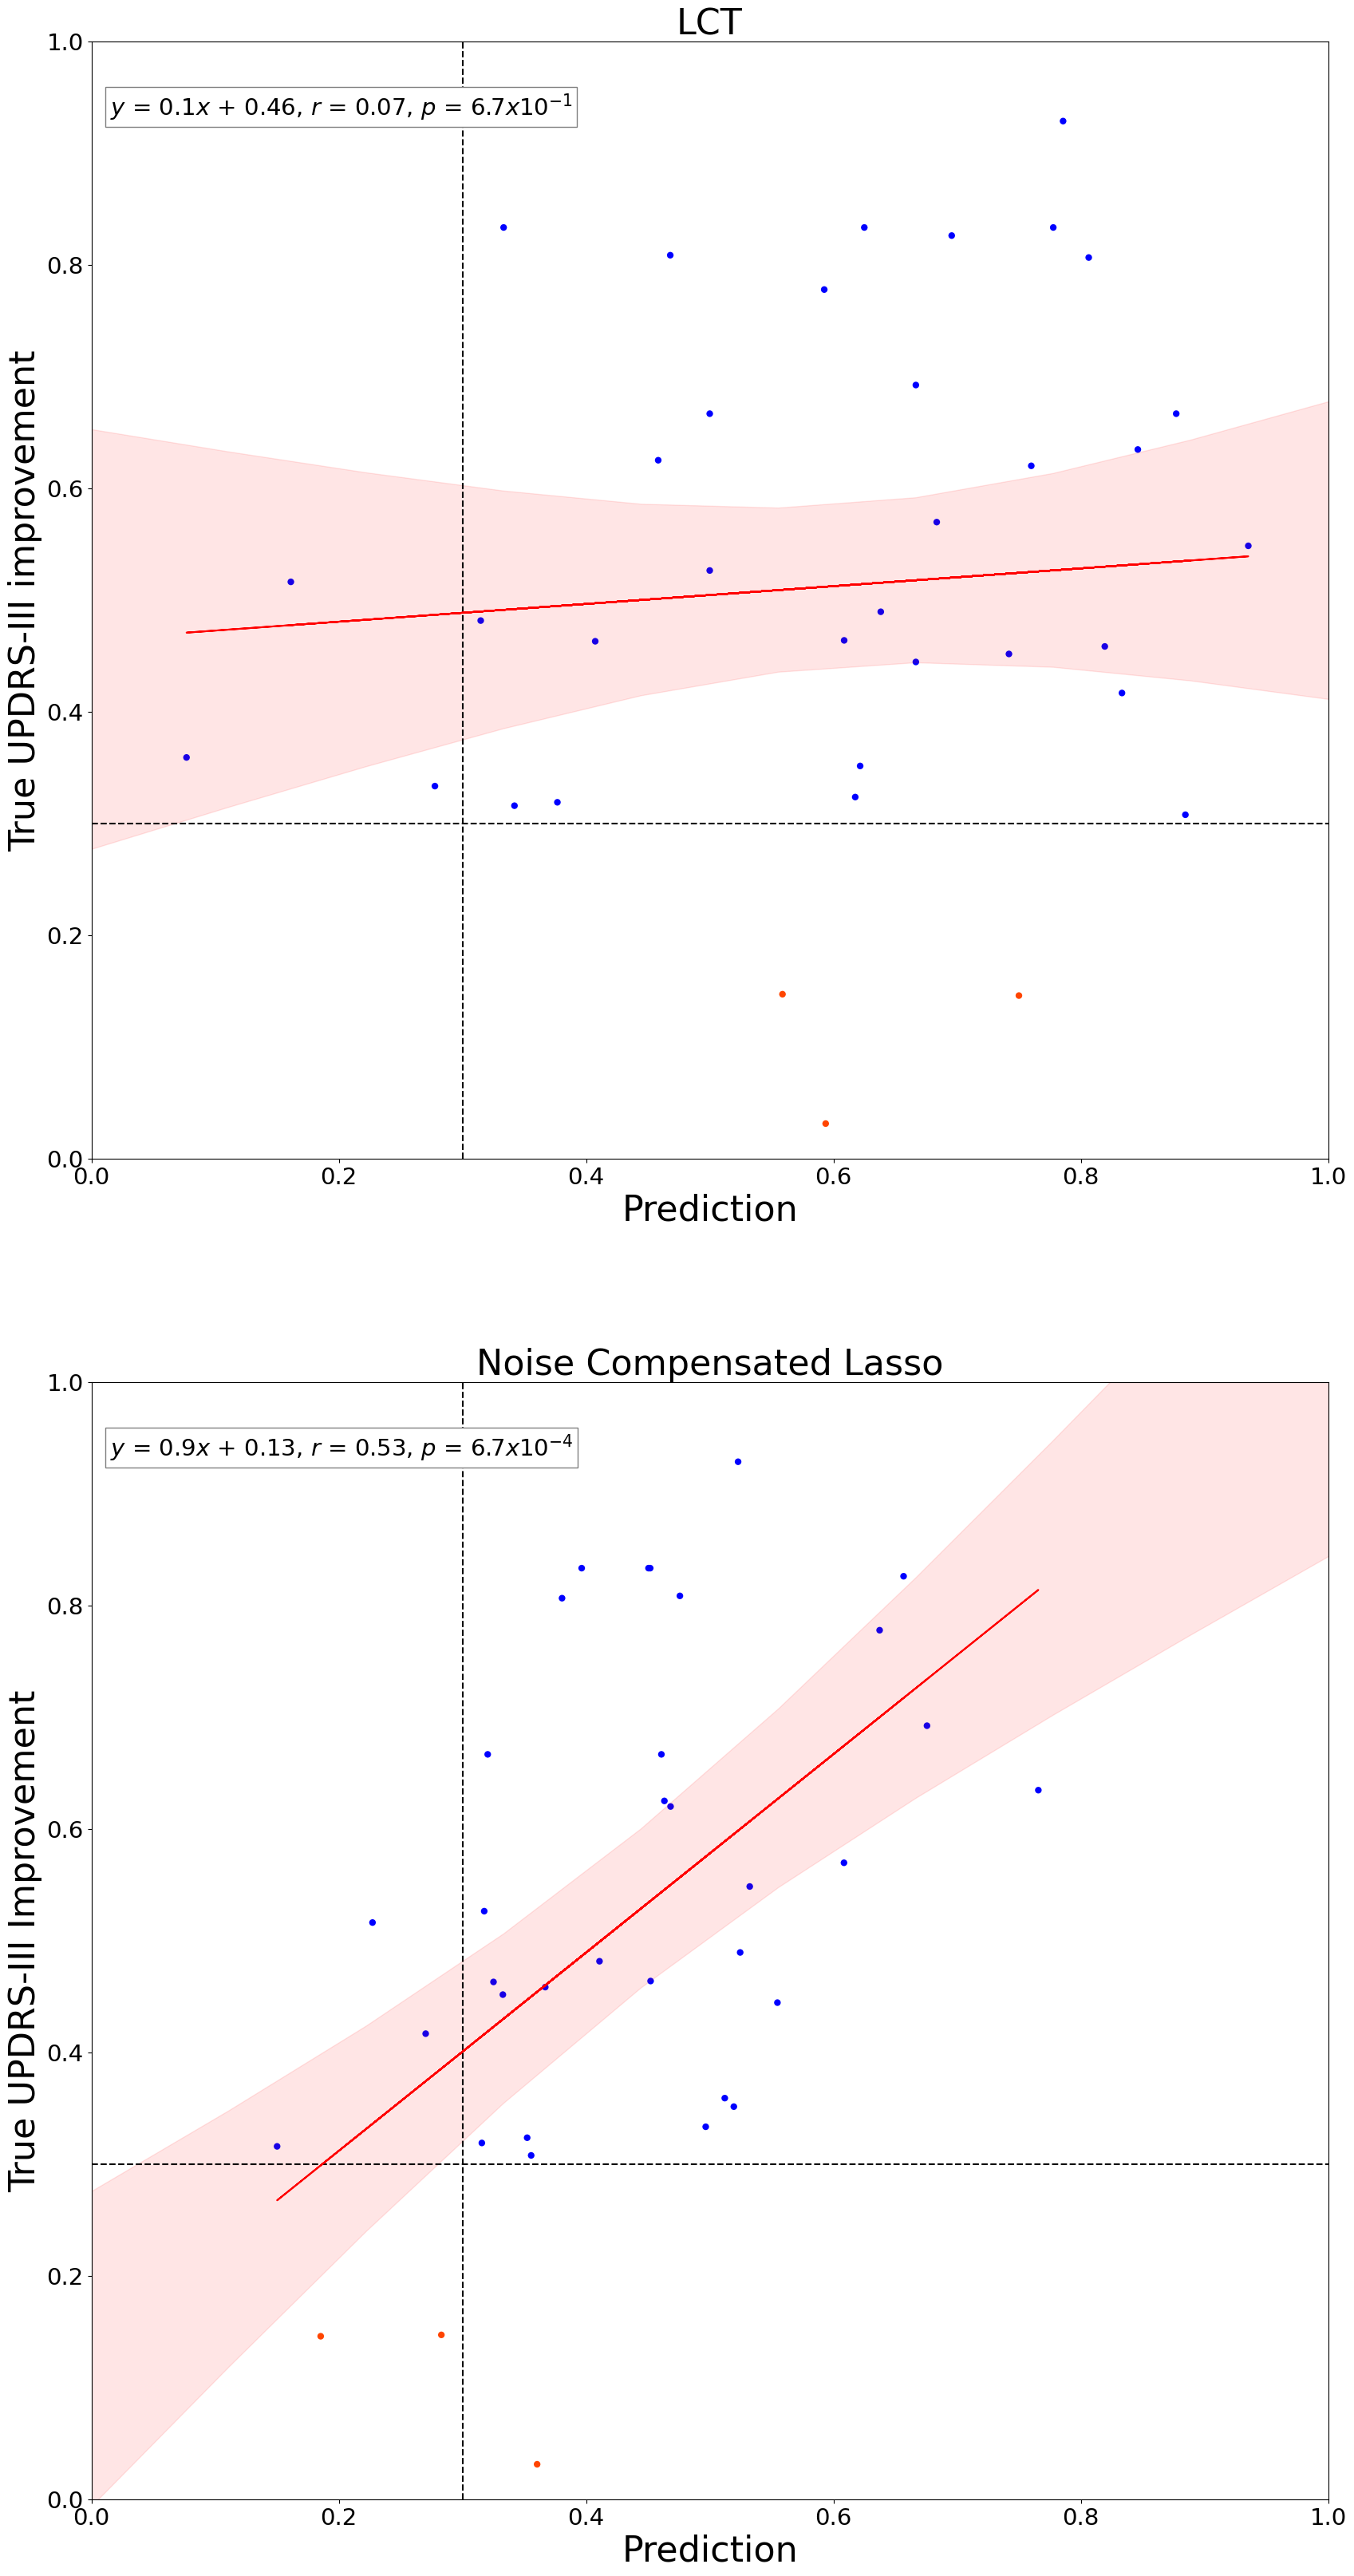

In [22]:
ylim = 1
fs = 32
ofx = 0.25
ofy = 0.745
pre_imp = np.repeat((np.asarray(pre_updrs_iii_off,dtype=float)-np.asarray(pre_updrs_iii_on,dtype=float))/np.asarray(pre_updrs_iii_off,dtype=float),r)
per_change = np.repeat(per_change,r)
plt.rcParams['figure.figsize'] = [20, 40]
fig,ax = plt.subplots(2,1,sharex=True,sharey=True)
col = np.where(per_change <= 0.3,'orangered','blue')
ax[0].scatter(pre_imp,per_change, c=col,linewidth=0)
lr = stats.linregress(pre_imp,per_change)
y_model = pre_imp*lr.slope+lr.intercept
ax[0].plot(pre_imp,y_model,color='r')
pl = r'$'+util.latex_sci(lr.pvalue,1)+'$'
ax[0].text(0.015,0.9275,'$y$ = '+str(np.round(lr.slope,1))+'$x$ + '+str(np.round(lr.intercept,2))+', '+'$r$ = '+str(np.round(lr.rvalue,2))+', '+'$p$ = '+pl,
                    ha='left', va='bottom', transform=ax[0].transAxes,fontsize=fs//1.5,
                    bbox=dict(facecolor='white', edgecolor='gray'))  
ci,pi,x_line,y_line = util.confidence_interval(pre_imp,per_change,11)
ax[0].fill_between(x_line,y_line+ci,y_line-ci,color = 'r',label = '95% confidence interval',alpha=0.1)
ax[0].hlines(0.3,0,2,linestyle='dashed',color='black')
ax[0].vlines(0.3,0,2,linestyle='dashed',color='black')
ax[0].xaxis.set_tick_params(labelleft=True,labelsize=fs//1.5)
ax[0].yaxis.set_tick_params(labelleft=True,labelsize=fs//1.5)
ax[0].set_title('LCT',fontsize=fs)
ax[0].set_xlabel('Prediction',fontsize=fs)
ax[0].set_ylabel('True UPDRS-III improvement',fontsize=fs)
plt.style.use('default')
plt.ylim([0,ylim])
plt.xlim([0,ylim])
extent = ax[0].get_window_extent().transformed(fig.dpi_scale_trans.inverted())

col = np.where(per_change <= 0.3,'orangered','blue')
ax[1].scatter(results_ls_aug,per_change, c=col,linewidth=0)
lr = stats.linregress(results_ls_aug,per_change)
y_model = results_ls_aug*lr.slope+lr.intercept
ci,pi,x_line,y_line = util.confidence_interval(results_ls_aug,per_change,11)
ax[1].plot(results_ls_aug,y_model,color='r')
pl = r'$'+util.latex_sci(lr.pvalue,1)+'$'
ax[1].text(0.015,0.9275,'$y$ = '+str(np.round(lr.slope,1))+'$x$ + '+str(np.round(lr.intercept,2))+', '+'$r$ = '+str(np.round(lr.rvalue,2))+', '+'$p$ = '+pl,
                    ha='left', va='bottom', transform=ax[1].transAxes,fontsize=fs//1.5,
                    bbox=dict(facecolor='white', edgecolor='gray'))  
ax[1].fill_between(x_line,y_line+ci,y_line-ci,color = 'r',label = '95% confidence interval',alpha=0.1)
ax[1].hlines(0.3,0,2,linestyle='dashed',color='black')
ax[1].vlines(0.3,0,2,linestyle='dashed',color='black')
ax[1].xaxis.set_tick_params(labelleft=True,labelsize=fs//1.5)
ax[1].yaxis.set_tick_params(labelleft=True,labelsize=fs//1.5)
ax[1].set_title('Noise Compensated Lasso',fontsize=fs)
ax[1].set_xlabel('Prediction',fontsize=fs)
ax[1].set_ylabel('True UPDRS-III Improvement',fontsize=fs)
plt.ylim([0,ylim])
plt.xlim([0,ylim])
plt.ylim([0,ylim])
plt.xlim([0,ylim])
extent = ax[1].get_window_extent().transformed(fig.dpi_scale_trans.inverted())


In [29]:
mf = ((6, 23, 30, 48, 55, 58, 68, 73, 75, 83, 85, 87, 90, 106, 107, 114, 115))
mrt = ((15, 26, 29, 44, 45, 46, 59, 62, 63, 92, 109, 110, 113))